<a href="https://colab.research.google.com/github/Ilvecho/Project_2/blob/main/P3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install thefuzz[speedup]
pass

In [2]:
import numpy as np
import pandas as pd
import re
from thefuzz import fuzz
from thefuzz import process
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

from google.colab import files
files.upload()
pass

Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [3]:
raw_data = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

# Preliminary data analysis

In [3]:
raw_data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
print(raw_data.isnull().sum())

id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64


In [4]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
print(duplicate_rows.sum())

51


there are 51 rows that are duplicates of already existing rows.
Note that to identify the duplicates we excluded the column 'id' as those are unique.

Ultimately, we need to understand whether these duplicate rows are actually duplicates, or simply represent different individuals with the same job title and number of connections.

I think that they are duplicate, as we detected rows with **excacly** the same job title and numebr of connections

In [5]:
# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


Let's look at the data distribution for each feature

In [ ]:
# let's start from the connection feature as it is the easiest to verify
raw_data.connection.value_counts()

In [6]:
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.reset_index().drop('index', axis=1)

In [53]:
unique_data.shape

(53, 5)

In [ ]:
job_title_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))
location_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))

In [ ]:
for index, row in unique_data.iterrows():
  # compute the similarity for Job Title
  tmp = process.extract(row.job_title, unique_data.job_title, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    job_title_similarity[index][idx] = score

  # compute the similarity for Location
  tmp = process.extract(row.location, unique_data.location, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    location_similarity[index][idx] = score

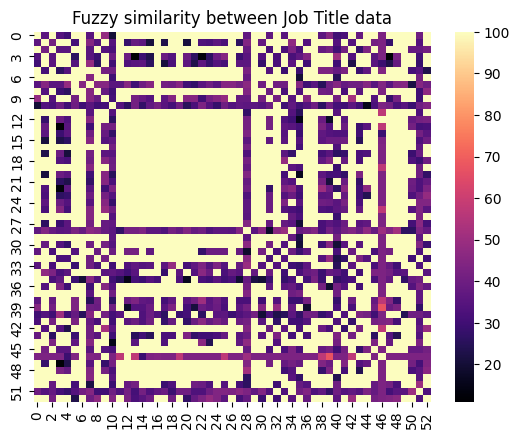

In [75]:
# plot the two results as heatmap
ax= plt.subplot()
sns.heatmap(job_title_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between Job Title data');
plt.show()

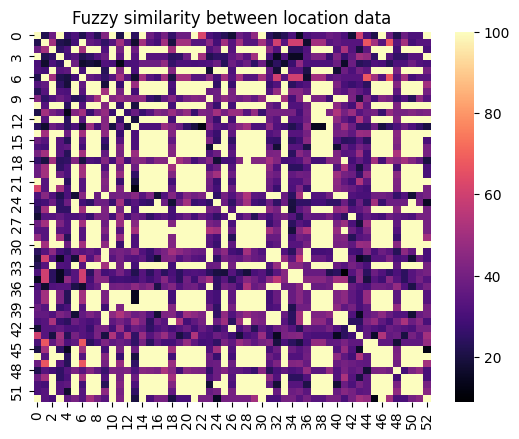

In [77]:
ax= plt.subplot()
sns.heatmap(location_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between location data');
plt.show()

In [78]:
process.extract("seeking human resources", unique_data.job_title, limit=3, scorer=fuzz.partial_token_set_ratio)

[('2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  100,
  0),
 ('Aspiring Human Resources Professional', 100, 2),
 ('Aspiring Human Resources Specialist', 100, 5)]

In [80]:
unique_data.location.value_counts()

Houston, Texas Area                    4
Raleigh-Durham, North Carolina Area    3
Greater New York City Area             3
Austin, Texas Area                     2
Amerika Birleşik Devletleri            2
Kanada                                 2
Greater Philadelphia Area              2
Greater Atlanta Area                   2
Torrance, California                   1
Highland, California                   1
Gaithersburg, Maryland                 1
Baltimore, Maryland                    1
Milpitas, California                   1
Greater Chicago Area                   1
Houston, Texas                         1
Long Beach, California                 1
Chattanooga, Tennessee Area            1
Bridgewater, Massachusetts             1
Lafayette, Indiana                     1
Kokomo, Indiana Area                   1
Las Vegas, Nevada Area                 1
Cape Girardeau, Missouri               1
Greater Los Angeles Area               1
Los Angeles, California                1
Dallas/Fort Wort

# Pre processing

First thing we convert the feature contact to int

In [112]:
# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

Then, we remove the duplicates

In [113]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.reset_index().drop('index', axis=1)

Pre-processing of the column location:

The goal is to obtain either a country, or CITY, STATE for US cities

- Remove the word 'Area'
- Remove the word 'Greater'
- Substitute 'Kanada' with 'Canada'

In [114]:
unique_data.location = unique_data.location.str.replace(' Area', '')
unique_data.location = unique_data.location.str.replace('Greater ', '')
unique_data.location = unique_data.location.str.replace('Kanada', 'Canada')

Now we need to identify different forms to indicate the same city: to do so we are going to use fuzzy matching

In [115]:
replacements = {}

for location in unique_data.location.unique():
  # compute the similarity for Job Title
  tmp = process.extract(location, unique_data.location.unique(), limit=3, scorer=fuzz.token_set_ratio)
  for i in np.arange(len(tmp)):
    # we have a match but the strings are not identical
    if tmp[i][1] > 90 and location != tmp[i][0]:
      # then, we replace the string WITHOUT comma (City name only) with the string WITH the comma (City, State)
      if ',' in location:
        replacements[tmp[i][0]] = location
      elif ',' in tmp[i][0]:
        replacements[location] = tmp[i][0]

for key in replacements.keys():
  unique_data.location = unique_data.location.mask(unique_data.location == key, other=replacements[key])

In [116]:
# Manual touch to accomodate my tastes
unique_data.location = unique_data.location.str.replace('York,', 'York City,')

In [117]:
# let's now check the strings that still don't contain a comma
for location in unique_data.location.value_counts().keys():
  if ',' not in location:
    print(location)

Amerika Birleşik Devletleri
Canada
Philadelphia
Dallas/Fort Worth
Boston
San Francisco Bay


In [118]:
# Manually fix this last surviving examples
unique_data.location = unique_data.location.str.replace('Philadelphia', 'Philadelphia, Pennsylvania')
unique_data.location = unique_data.location.str.replace('Dallas/Fort Worth', 'Dallas, Texas')
unique_data.location = unique_data.location.str.replace('Boston', 'Boston, massachusetts')
unique_data.location = unique_data.location.str.replace('San Francisco Bay', 'San Francisco, California')

# Amerika Birleşik Devletleri in turkish means United States of America
unique_data.location = unique_data.location.str.replace('Amerika Birleşik Devletleri', 'United States')

In [119]:
# Now that we have (almost) all the locations as city, state
# we split them
city_list = []
state_list = []


for index, row in unique_data.iterrows():
  # compute the similarity for Job Title
  if ',' not in row.location:
    city_list.append('')
    state_list.append(row.location)
  else:
    city, state = row.location.split(', ')
    city_list.append(city)
    state_list.append(state)

In [125]:
unique_data['city'] = city_list
unique_data['state'] = state_list

In [123]:
px.bar(x=unique_data.location.value_counts().keys(), y=unique_data.location.value_counts(), title='Location bar plot')

In [127]:
px.bar(x=unique_data.city.value_counts().keys(), y=unique_data.city.value_counts(), title='City bar plot')

In [128]:
px.bar(x=unique_data.state.value_counts().keys(), y=unique_data.state.value_counts(), title='State bar plot')